In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "dataR2.csv"
df = pd.read_csv(file_path)

X = df.drop(columns=["Classification"])  
y = df["Classification"]

# (80%) de treino e validaçao / (20%) de teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 60% de treino / 20% de validação 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Tamanho treino:      {len(X_train)}")
print(f"Tamanho validação:   {len(X_val)}")
print(f"Tamanho teste:       {len(X_test)}")

X_train.to_csv("X_train.csv", index=False)  



Tamanho treino:      69
Tamanho validação:   23
Tamanho teste:       24


In [72]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal

#--------------------------feature selection --------------------------
#Kruskal-Wallis
kruskal_selected_features = []
p_values = {}
classes = np.unique(y_train)
for feature in X_train.columns:
    groups = []
    for have_c in classes:
        groups.append(X_train.loc[y_train == have_c, feature]) #faz uma lista dependendo do valor do classification

    stat, p = kruskal(*groups) #stat fica com o valor H e p fica com o p-value
    p_values[feature] = p
    
    # Selecionar features com diferença estatisticamente significativa  (5% significance level)
    if p < 0.05:
        kruskal_selected_features.append(feature)
        print(f"Feature: {feature}, Kruskal-Wallis H-statistic: {stat}, p-value: {p}")


print("kruskal_selected_features:", kruskal_selected_features)


# Reduzir datasets apenas às features selecionadas pelo Kruskal-Wallis
X_krus_train_sel = X_train[kruskal_selected_features]
X_krus_val_sel = X_val[kruskal_selected_features]
X_krus_test_sel = X_test[kruskal_selected_features]




# ROC-AUC
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# --- prepara dados (y_train e X_train já definidos) ---
classes = np.unique(y_train)
pos_label = classes[-1]   # define a classe positiva como a de maior valor (ex: 1 ou 2)

fnames = np.array(X_train.columns)
roc_auc = np.zeros(fnames.shape)

# --- calcular curvas ROC e AUC para cada feature ---
i = 0
for f in fnames:
    x_feat = X_train[f].to_numpy().astype(float)
    y_true = y_train.to_numpy()

    # curva ROC + AUC
    fpr, tpr, _ = roc_curve(y_true, x_feat, pos_label=pos_label)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1 - a  # inverter direção se necessário
    roc_auc[i] = a

    # # --- plot -> utilizar este codigo para relatorio  ---
    # figR = go.Figure()
    # figR.add_scatter(x=fpr, y=tpr, mode='lines+markers')
    # figR.update_layout(autosize=False, width=700, height=700, title=dict(text=f))
    # figR.update_xaxes(title_text="1 - Specificidade (FPR)", range=[-0.01, 1.01])
    # figR.update_yaxes(title_text="Sensibilidade (TPR)", range=[-0.01, 1.01])
    # figR.add_annotation(x=0.5, y=0.5, text=f"AUC: {a:.3f}", showarrow=False, yshift=10)
    # figR.show()
    i += 1



# --- selecionar features com AUC acima do limiar (ex: 0.60) ---
roc_auc_selected_features = fnames[roc_auc > 0.60]
print("roc_auc_selected_features:", roc_auc_selected_features)

# --- reduzir os datasets ---
X_auc_train_sel = X_train[roc_auc_selected_features]
X_auc_val_sel   = X_val[roc_auc_selected_features]
X_auc_test_sel  = X_test[roc_auc_selected_features]


# Matriz de Correlação entre todas as features (treino)
import plotly.express as px

X = X_train[kruskal_selected_features].to_numpy().T
corrMat = np.corrcoef(X)
eatures = X_train[kruskal_selected_features].columns.tolist()
fig = px.imshow(
    corrMat,
    text_auto=True,
    labels=dict(x="Features", y="Features", color="Correlação"),
    x=eatures,
    y=eatures,
    width=1000,
    height=1000,
    color_continuous_scale=px.colors.sequential.gray
)
fig.update_layout(title="Matriz de Correlação entre TODAS as Features (Treino)")
fig.show()


Feature: Glucose, Kruskal-Wallis H-statistic: 21.882684786313593, p-value: 2.8983742948778834e-06
Feature: Insulin, Kruskal-Wallis H-statistic: 6.7897432455439075, p-value: 0.009168309393118787
Feature: HOMA, Kruskal-Wallis H-statistic: 10.142517584283269, p-value: 0.0014488814663522185
Feature: Resistin, Kruskal-Wallis H-statistic: 4.873490177055544, p-value: 0.027272288979371395
kruskal_selected_features: ['Glucose', 'Insulin', 'HOMA', 'Resistin']
roc_auc_selected_features: ['Glucose' 'Insulin' 'HOMA' 'Resistin']


In [73]:
#Removemos a insulina pq tem alta correlaçao com a homa mas tem um p-value mais alto 
kruskal_selected_features.remove('Insulin')
print("kruskal_selected_features after removing Insulin:", kruskal_selected_features)


kruskal_selected_features after removing Insulin: ['Glucose', 'HOMA', 'Resistin']


Eigenvalues / Explained Variance:
[1.02681235e+02 8.18764703e-01 4.18258444e-31]
Sum of eigenvalues: 103.5
Eigenvectors / Principal Components:
[[ 1.20757077e-01  5.71515457e-02  7.97354319e-01]
 [ 1.20853683e-01 -1.84148882e-02 -5.41058986e-02]
 [ 1.20496083e-01  1.05654273e-01  6.37681468e-02]
 [ 1.20859764e-01  1.24401020e-02 -1.23852672e-01]
 [ 1.20259196e-01  1.35333585e-01  6.13821004e-03]
 [ 1.20439924e-01 -1.13400693e-01 -6.98845224e-02]
 [ 1.20692155e-01 -7.23336442e-02  1.44777146e-02]
 [ 1.19889389e-01 -1.71617741e-01 -7.76153251e-03]
 [ 1.20599245e-01  8.96863024e-02 -8.31862400e-03]
 [ 1.20863159e-01  7.20058002e-03  1.61816937e-02]
 [ 1.20820243e-01 -3.67780705e-02 -5.96510639e-02]
 [ 1.20791142e-01 -4.72692769e-02  7.91298433e-02]
 [ 1.20672691e-01 -7.62976253e-02  5.18808164e-03]
 [ 1.20795857e-01  4.57332352e-02 -1.19020414e-01]
 [ 1.20731820e-01  6.34917635e-02  8.91125205e-02]
 [ 1.20628266e-01  8.46503649e-02 -4.39945360e-02]
 [ 1.20813240e-01 -3.95580686e-02  1.006

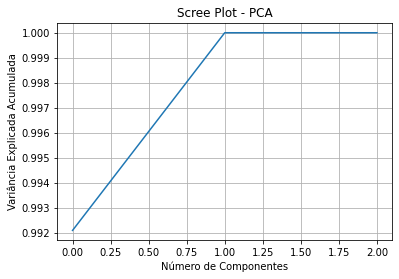

In [ ]:
# --------------------dimensionality reduction --------------
X = X_train[kruskal_selected_features].to_numpy().T

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandardizar (importante no PCA)
X_std = StandardScaler().fit_transform(X)

# Ajustar PCA
pca = PCA()
pca.fit(X_std)

# Variância explicada
print("Eigenvalues / Explained Variance:")
print(pca.explained_variance_)
print("Sum of eigenvalues:", np.sum(pca.explained_variance_))

# Componentes principais (autovetores)
print("Eigenvectors / Principal Components:")
print(pca.components_.T)

# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("Scree Plot - PCA")
plt.grid(True)
plt.show()
